# Single Stock Analysis

The notebook here allows to perform analysis for a single exchange security.

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Data downloading

In [14]:
start = '2012-01-01'
end = '2017-12-31'
stock_symbol = 'MAB'

# Uncomment line below to download latest quotes for stocks
#%run ../money_machine_app/downloaders/stocks_data_downloader.py $start $end $stock_symbol


# Data preprocessing

In [15]:
# The CSV file has following columns: 
# Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen
stock = pd.read_csv(f'./data-archive/stocks/{stock_symbol}.csv',
                   delimiter=',',
                   index_col='Data',
                   parse_dates=True)

In [16]:
# drop unnecessary columns
stock.drop(['Otwarcie', 'Najwyzszy', 'Najnizszy'], axis=1, inplace=True)

# rename column and index
stock.columns = ['Close', 'Volume']
stock.index.names = ['Date']

In [17]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2012-01-02 to 2017-10-19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1439 non-null   float64
 1   Volume  1439 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 33.7 KB


# Analysis

## Normalize Price

This is same as cumulative daily returns.

In [18]:
stock['Normed Return'] = stock['Close'] / stock.iloc[0]['Close']

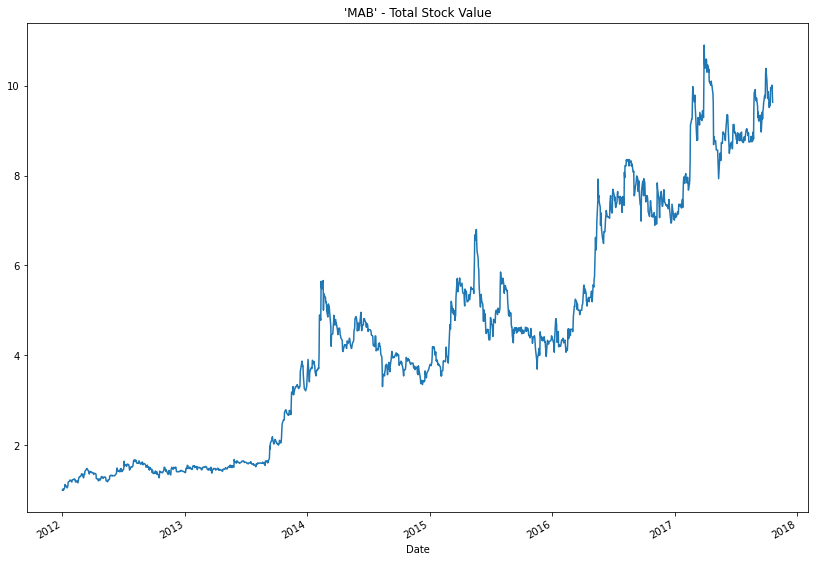

In [19]:
stock['Normed Return'].plot(figsize=(14,10))
plt.title(f"'{stock_symbol}' - Total Stock Value");

# Statistics

In [20]:
stock['Daily Return'] = stock['Close'].pct_change(1)

In [21]:
stock.tail()

,Close,Volume,Normed Return,Daily Return
Date,,,,
2017-10-13,105.50,4834,9.962229,0.032795
2017-10-16,105.35,1596,9.948064,-0.001422
2017-10-17,106.05,1325,10.014164,0.006645
2017-10-18,104.50,4064,9.867800,-0.014616
2017-10-19,102.00,11340,9.631728,-0.023923


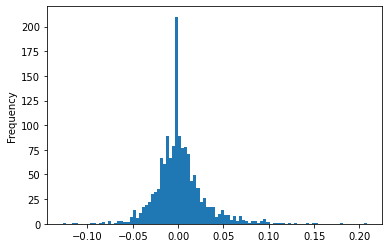

In [23]:
stock['Daily Return'].plot(kind='hist', bins=100);

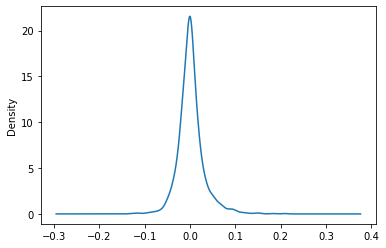

In [24]:
stock['Daily Return'].plot(kind='kde');

# Average Daily Return


In [25]:
stock['Daily Return'].mean()

0.0019833095425608287

Std Daily Return

In [26]:
stock['Daily Return'].std()

0.02882976725840105

In [27]:
SR = stock['Daily Return'].mean() / stock['Daily Return'].std()

if SR <= 1:
    print(f'Sharpe Ratio = {SR}. Too risky asset.')
elif SR <= 2:
    print(f'Sharpe Ratio = {SR}. Good.')
elif SR <= 3:
    print(f'Sharpe Ratio = {SR}. Great.')
else:
    print(f'Sharpe Ratio = {SR}. Excellent.')

Sharpe Ratio = 0.06879381039688721. Too risky asset.


In [28]:
ASR = (252**0.5) * SR
print(f'Annual Sharpe Ratio = {ASR}')

Annual Sharpe Ratio = 1.0920678843041594


# Moving Average

SMA

In [29]:
sma_1 = 10
sma_2 = 30

stock[f'SMA {sma_1}'] = stock['Close'].rolling(window=sma_1).mean()
stock[f'SMA {sma_2}'] = stock['Close'].rolling(window=sma_2).mean()

# crossovers
stock['signal'] = 0.0
stock['signal'][sma_1:] = np.where(stock[f'SMA {sma_1}'][sma_1:] > stock[f'SMA {sma_2}'][sma_1:], 1.0, 0.0)
stock['positions'] = stock['signal'].diff()

<ipython-input-29-b73196c09cbc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['signal'][sma_1:] = np.where(stock[f'SMA {sma_1}'][sma_1:] > stock[f'SMA {sma_2}'][sma_1:], 1.0, 0.0)


No handles with labels found to put in legend.


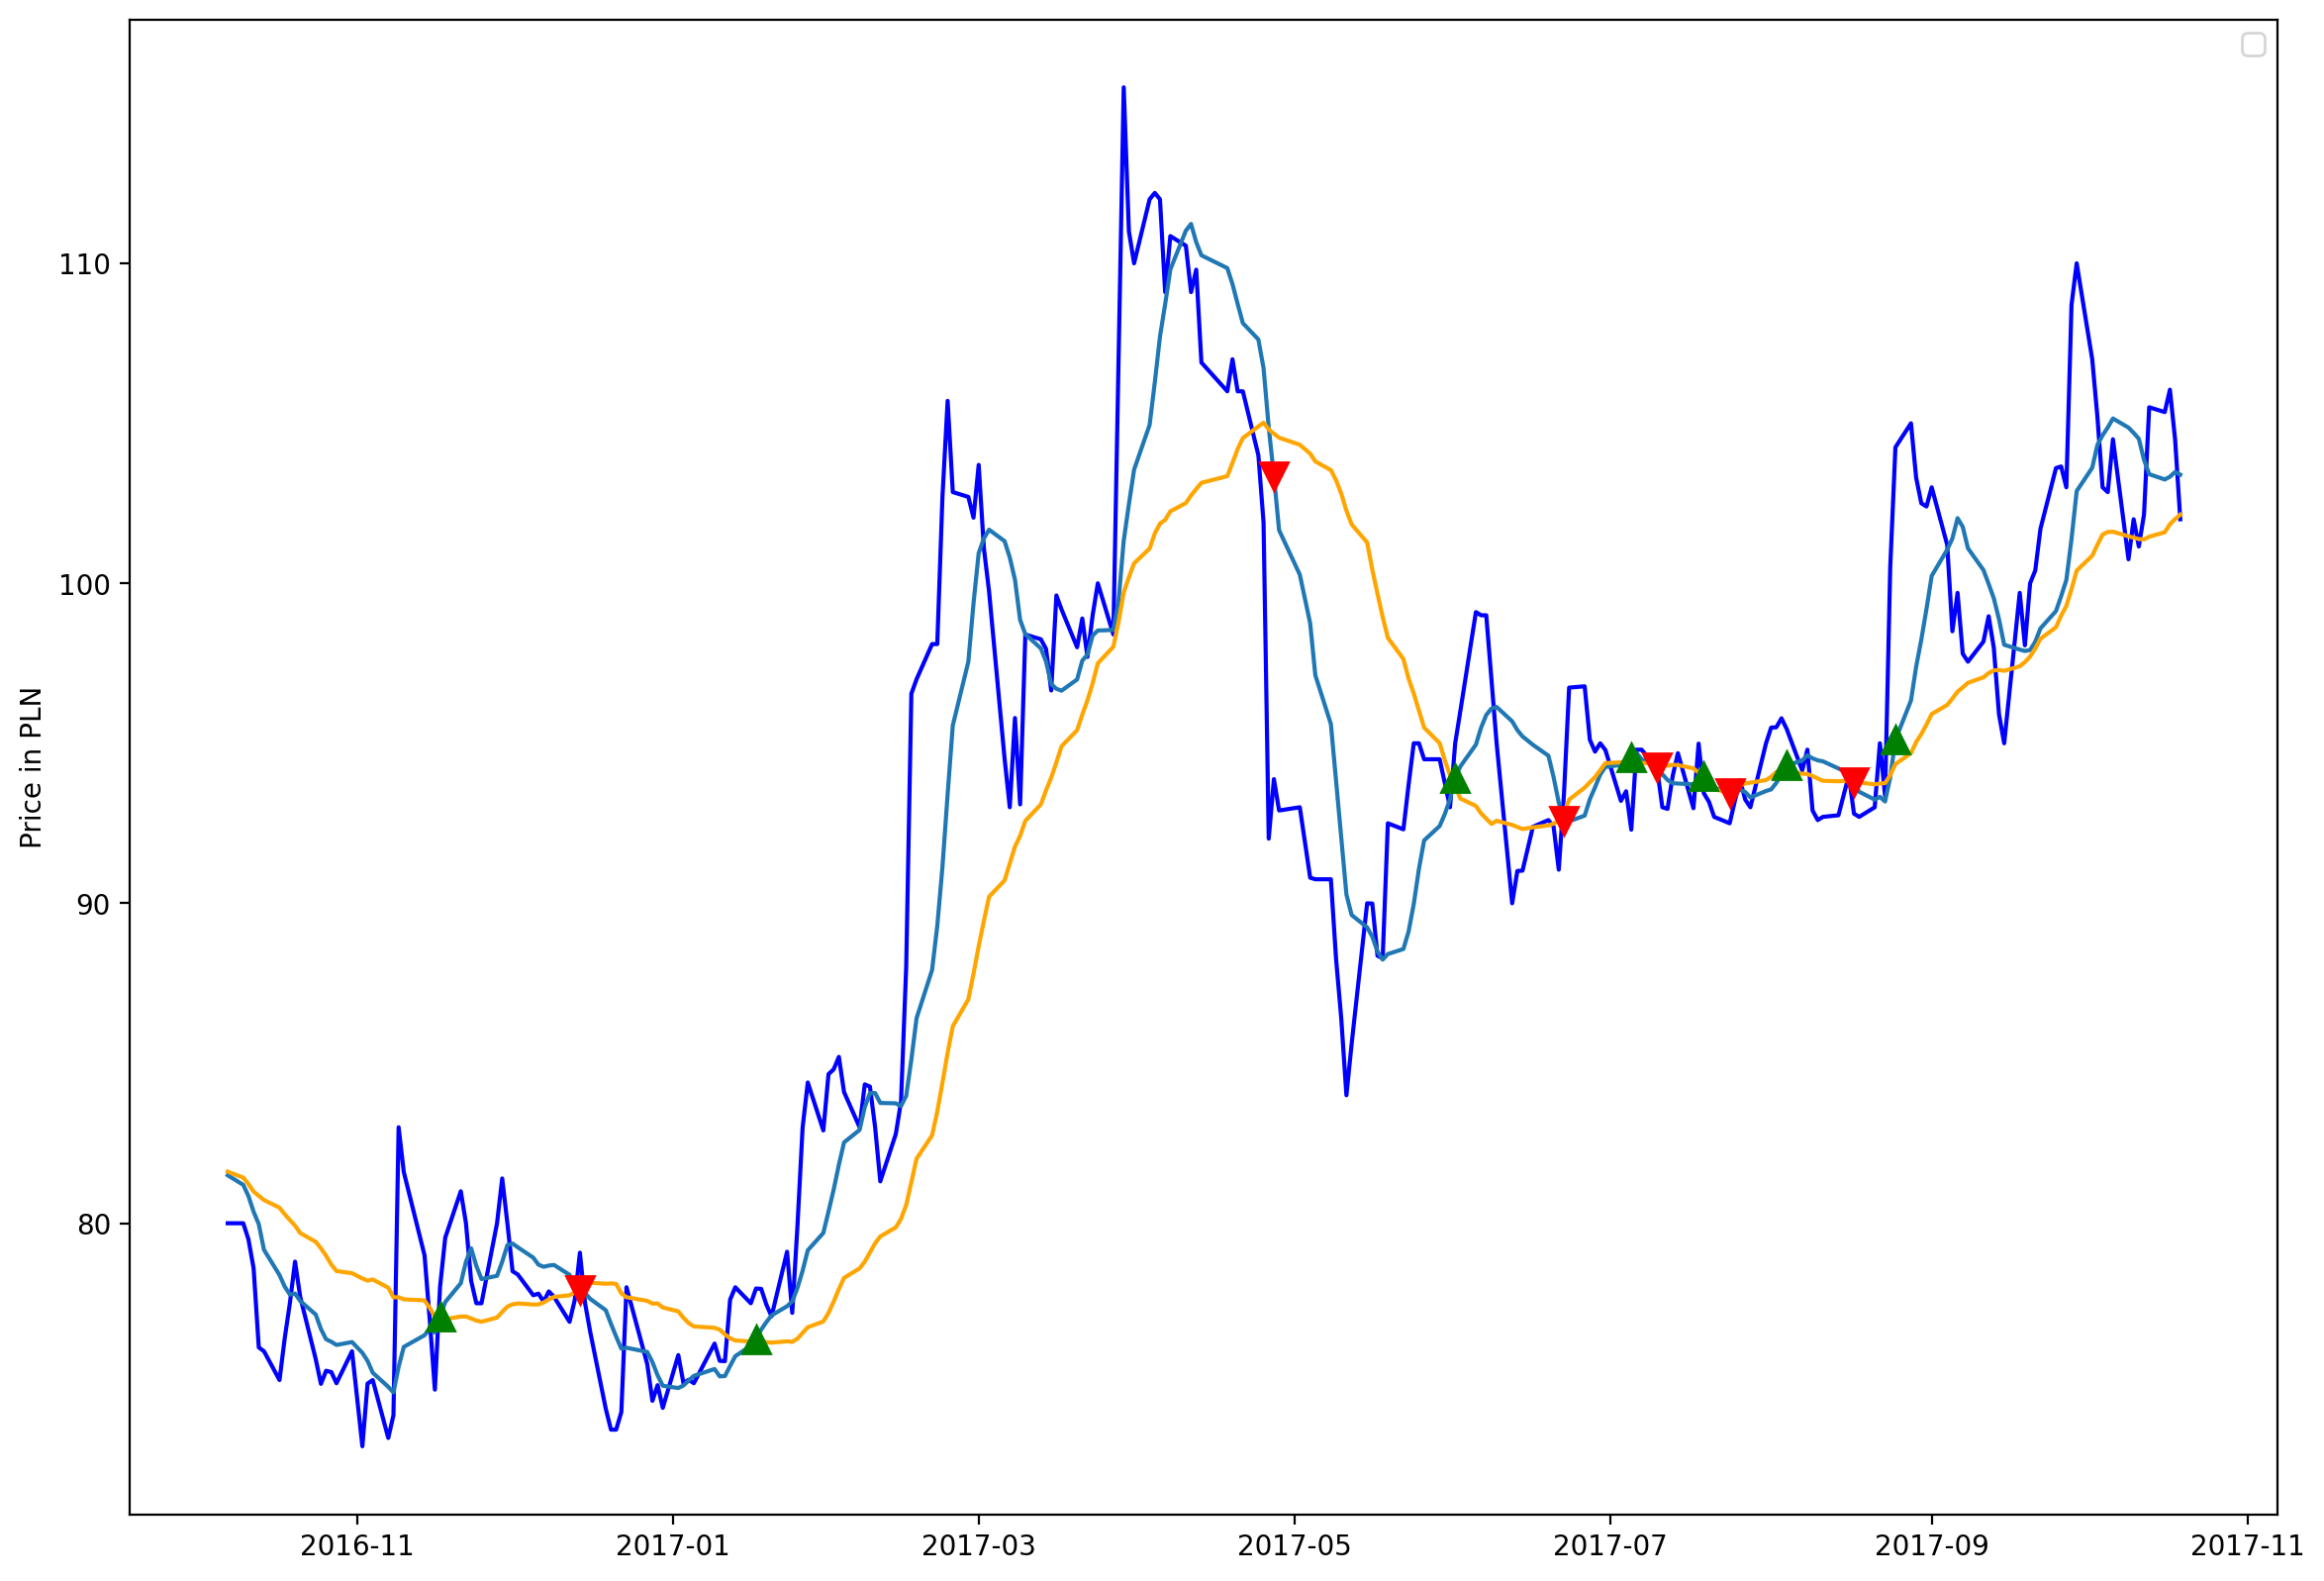

In [30]:
recent_stock = stock.tail(260);

fig = plt.figure(figsize=(14,10), dpi=200);
fig.patch.set_facecolor('white');     # Set the outer colour to white
ax1 = fig.add_subplot(111, ylabel='Price in PLN');

#stock['Close'].tail(260).plot(ax=ax1, color='r');
#stock[[f'SMA {sma_1}', f'SMA {sma_2}']].tail(260).plot(ax=ax1);

ax1.plot(recent_stock['Close'], color='blue')
ax1.plot(recent_stock[f'SMA {sma_1}'])
ax1.plot(recent_stock[f'SMA {sma_2}'], color='orange')

# Plot the "buy" trades
ax1.plot(recent_stock[recent_stock["positions"] == 1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock["positions"] == 1.0],
         '^', markersize=10, color='g');

# Plot the "sell" trades
ax1.plot(recent_stock[recent_stock["positions"] == -1.0].index, 
         recent_stock[f'SMA {sma_1}'][recent_stock['positions'] == -1.0],
         'v', markersize=10, color='r');

ax1.legend();

Suggested 'Buy' dates

In [32]:
recent_stock[recent_stock["positions"] == 1.0].index.tolist()

[Timestamp('2016-11-17 00:00:00'),
 Timestamp('2017-01-17 00:00:00'),
 Timestamp('2017-06-01 00:00:00'),
 Timestamp('2017-07-05 00:00:00'),
 Timestamp('2017-07-19 00:00:00'),
 Timestamp('2017-08-04 00:00:00'),
 Timestamp('2017-08-25 00:00:00')]

Suggested 'Sell' dates

In [33]:
recent_stock[recent_stock["positions"] == -1.0].index.tolist()

[Timestamp('2016-12-14 00:00:00'),
 Timestamp('2017-04-27 00:00:00'),
 Timestamp('2017-06-22 00:00:00'),
 Timestamp('2017-07-10 00:00:00'),
 Timestamp('2017-07-24 00:00:00'),
 Timestamp('2017-08-17 00:00:00')]

Bollinger Bands

In [35]:
stock['SMA 20'] = stock['Close'].rolling(window=20).mean()
stock['B-Band Upper'] = stock['SMA 20'] + 2*stock['Close'].rolling(window=20).std()
stock['B-Band Lower'] = stock['SMA 20'] - 2*stock['Close'].rolling(window=20).std()